### Get Dataset from request

This cell imports all required packages and sets up the logging as well as the required information for the requests to the TOAR-DB.

In [1]:
from datetime import datetime as dt
from pathlib import Path

import pandas as pd
import numpy as np

from toargridding.grids import RegularGrid
from toargridding.toar_rest_client import (
    AnalysisServiceDownload,
    STATION_LAT,
    STATION_LON,
)
from toargridding.metadata import Metadata, TimeSample, AnalysisRequestResult, Coordinates
from toargridding.variables import Coordinate

from toargridding.contributors import contributions_manager_by_id

import logging
from toargridding.defaultLogging import toargridding_defaultLogging
#setup of logging
logger = toargridding_defaultLogging()
logger.addShellLogger(logging.DEBUG)
logger.logExceptions()

endpoint = "https://toar-data.fz-juelich.de/api/v2/analysis/statistics/"
#starts in directory [path/to/toargridding]/tests
#maybe adopt the toargridding_base_path for your machine.
toargridding_base_path = Path(".")
cache_dir = toargridding_base_path / "cache"
data_download_dir = toargridding_base_path / "results"

cache_dir.mkdir(exist_ok=True)
data_download_dir.mkdir(exist_ok=True)
analysis_service = AnalysisServiceDownload(endpoint, cache_dir, data_download_dir, use_downloaded=True)
my_grid = RegularGrid(1.9, 2.5)

time = TimeSample(dt(2016,1,1), dt(2016,2,28), "daily")
metadata = Metadata.construct("mole_fraction_of_ozone_in_air", time, "mean")


2024-09-12 10:49:49 [WARNING] - variables.py:103: 'Resolution 1.9 does not provide an equidistant division of the span [-90,90]'
2024-09-12 10:49:49 [WARNING] - variables.py:108: 'Adoption resolution 1.9 to 1.894736842105263'


In the next step we want to download the data and store them to disc. 

In [2]:
# this cell can runs longer than 30minutes
data = analysis_service.get_data(metadata)

# create contributors endpoint and write result to metadata
contrib = contributions_manager_by_id(metadata.get_id(), data_download_dir)
contrib.extract_contributors_from_data_frame(data.stations_data)
metadata.contributors_metadata_field = contrib.setup_contributors_endpoint_for_metadata()
ds = my_grid.as_xarray(data)
#store dataset
ds.to_netcdf(data_download_dir / f"{metadata.get_id()}_by_names_inline_{my_grid.get_id()}.nc")

2024-09-12 10:49:49 [INFO] - toar_rest_client.py:599: 'Loading already downloaded data to file results/mean_daily_mole_fraction_of_ozone_in_air_2016-01-01_2016-02-28_.zip'
2024-09-12 10:49:49 [INFO] - toar_rest_client.py:507: 'Dropping columns ([Timestamp('2015-12-31 00:00:00'), Timestamp('2016-02-29 00:00:00')]) from TOAR data to match requested date range [2016-01-01 00:00:00, 2016-02-28 00:00:00]'


### Visual inspection
We now clean the station metadata. Therefore we remove all stations which have invalid coordinates

In [3]:
#calculation of coordinates for plotting
#especially separation of coordinates with results and without results.

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

mean_data = ds["mean"]
clean_coords = data.stations_coords
all_na = data.stations_data.isna().all(axis=1)
clean_coords = all_na.to_frame().join(clean_coords)[["latitude", "longitude"]]
all_na_coords = clean_coords[all_na]
not_na_coords = clean_coords[~all_na]

In the next step we prepare a function for plotting the gridded data to a world map. The flag *discrete* influences the creation of the color bar. The *plot_stations* flag allows including the station positions into the map.

In [4]:
import matplotlib as mpl

#definition of plotting function

def plot_cells(data, stations, na_stations, discrete=True, plot_stations=False):
    fig = plt.figure(figsize=(9, 18))

    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.left_labels = False
    gl.xlocator = mticker.FixedLocator(data.longitude.values)
    gl.ylocator = mticker.FixedLocator(data.latitude.values)

    cmap = mpl.cm.viridis

    if discrete:
        print(np.unique(data.values))
        bounds = np.arange(8)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend="both")
        ticks = np.arange(bounds.size + 1)[:-1] + 0.5
        ticklables = bounds
        
        im = plt.pcolormesh(
            data.longitude,
            data.latitude,
            data,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            shading="nearest",
            norm=norm,
        )
        cb = fig.colorbar(im, ax=ax, shrink=0.2, aspect=25)
        cb.set_ticks(ticks)
        cb.set_ticklabels(ticklables)
        im = plt.pcolormesh(
            data.longitude,
            data.latitude,
            data,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            shading="nearest",
            norm=norm,
        )
    else:
        im = plt.pcolormesh(
            data.longitude,
            data.latitude,
            data,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            shading="nearest",
        )

        cb = fig.colorbar(im, ax=ax, shrink=0.2, aspect=25)
    

    if plot_stations:
        plt.scatter(na_stations["longitude"], na_stations["latitude"], s=1, c="k")
        plt.scatter(stations["longitude"], stations["latitude"], s=1, c="r")

    plt.tight_layout()

    plt.title(f"global ozon at {data.time.values} {data.time.units}")

Now we do the actual plotting. We select a single time from the dataset. To obtain two maps: 1) the mean ozone concentration per grid point and second the number of stations contributing to a grid point.

         latitude   longitude
id                           
73      50.754704    6.093923
250     13.775373  100.568928
317     29.733726  -95.257593
325     29.144291  -95.756601
329     30.236200  -95.483200
...           ...         ...
421210  55.584747   13.006230
421218  58.806107   17.388050
421219  55.606390   13.001960
421231  55.703336   13.180275
421235  59.316007   18.057807

[5052 rows x 2 columns]


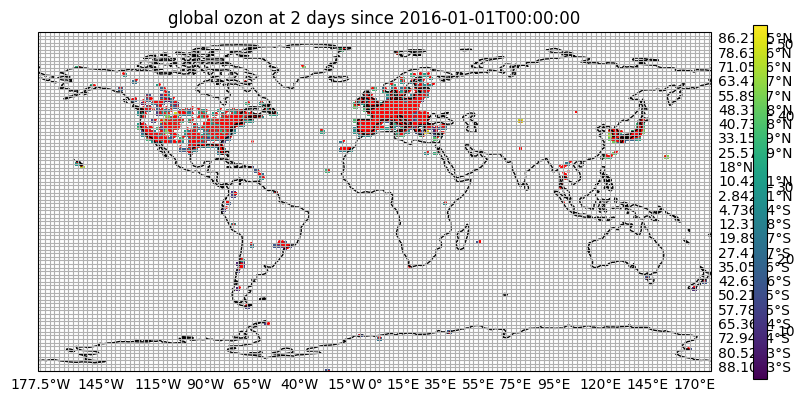

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  39.  40.  46.  49.  51.  54.  55.  56.  57.
  61.  62.  63.  68.  72.  75.  81.  85.  87. 116. 147. 217. 322.  nan]


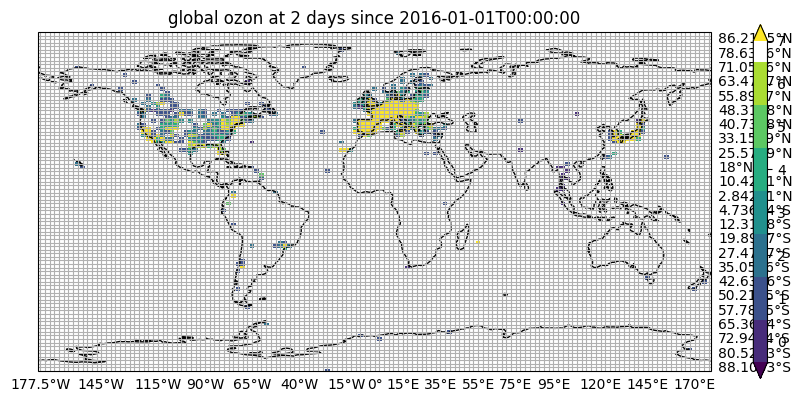

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  36.  37.  38.  39.  40.  41.  42.
  44.  45.  46.  47.  48.  49.  51.  52.  53.  54.  55.  56.  57.  58.
  59.  60.  61.  62.  63.  64.  65.  66.  68.  70.  71.  72.  73.  74.
  75.  76.  77.  80.  81.  82.  83.  84.  85.  86.  87.  88. 114. 115.
 116. 117. 146. 147. 148. 149. 150. 211. 212. 213. 214. 215. 216. 217.
 218. 316. 318. 319. 320. 321. 322. 323. 324. 325.  nan]


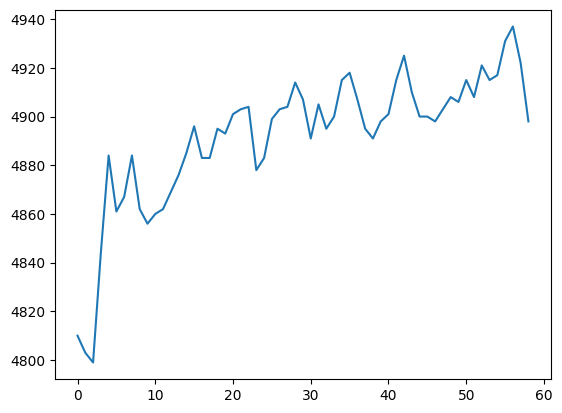

In [5]:
#example visualization for two time points
print(not_na_coords)
timestep = 2
time = ds.time[timestep]
data = ds.sel(time=time)

plot_cells(data["mean"], not_na_coords, all_na_coords, discrete=False, plot_stations=True)
plt.show()

plot_cells(data["n"], not_na_coords, all_na_coords, discrete=True)
plt.show()

n_observations = ds["n"].sum(["latitude", "longitude"])
plt.plot(ds.time, n_observations)
print(np.unique(ds["n"]))

Last but not least: We print the data and metadata of the dataset. Especially a look into the metadata can be interesting.

In [6]:
print(data)

<xarray.Dataset> Size: 334kB
Dimensions:    (latitude: 96, longitude: 144)
Coordinates:
    time       int64 8B 2
  * latitude   (latitude) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * longitude  (longitude) float64 1kB -180.0 -177.5 -175.0 ... 175.0 177.5
Data variables:
    mean       (latitude, longitude) float64 111kB nan nan nan ... nan nan nan
    std        (latitude, longitude) float64 111kB nan nan nan ... nan nan nan
    n          (latitude, longitude) float64 111kB nan nan nan ... nan nan nan
Attributes: (12/33)
    id:                        o3_mean_2016-01-01T00:00:00to2016-02-29T00:00:...
    title:                     daily mean statistic for mole_fraction_of_ozon...
    summary:                   daily mean statistic for mole_fraction_of_ozon...
    date_created:              2024-09-12T08:49:49Z
    history:                   2024-09-12T08:49:49Z: File created by toargrid...
    geospatial_lat_min:        -90
    ...                        ...
    creator